In [1]:

import os
import errno
import shutil
import tensorflow as tf
import pickle
import subprocess
from numpy import asarray
from lookahead_tensorflow import Lookahead
from PIL import Image
from tensorflow.keras.utils import to_categorical
from keras_radam.training import RAdamOptimizer
import tensorflow.keras.backend as K
import cv2
import sklearn
import glob
from statistics import mean,stdev 
import matplotlib.pyplot as plt
import seaborn as sns

worker_num = 12

#####################################
#####################################
#####The only parameters to modify!!!
gpu = '0'

#####################################
#####################################

import model_util as mu


os.environ["OMP_NUM_THREADS"] = str(worker_num) 
os.environ["OPENBLAS_NUM_THREADS"] = str(worker_num) 
os.environ["MKL_NUM_THREADS"] = str(worker_num) 
os.environ["VECLIB_MAXIMUM_THREADS"] = str(worker_num)
os.environ["NUMEXPR_NUM_THREADS"] = str(worker_num)
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]= gpu
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = '1'

batch_num = 64
width = 300
length = 225
trainable = True
epoch_num = 250
layer_out = 'block4_pool'
inter_out = 1

weights_dir = 'none'
save_best = False

pooling_mode = 'avg'

model_warehouse = '/home/eason/warehouse/models_saved/'

from tensorflow.keras.applications import VGG16 as select_model

dtype = 'float32'
K.set_floatx(dtype)

if dtype == 'float32':
    K.set_epsilon(1e-7)
else:
    K.set_epsilon(1e-4)

valid_split = 0
test_step = 1
check_step = 10
fcnode = 256
num_fc = 2
category_num = 1
monitor_matrics = 'binary_accuracy'
save_matrics = 'val_binary_accuracy'
auto_shut = False

color_mode = 'rgb'
class_mode = 'binary'

from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import EarlyStopping,Callback,ModelCheckpoint,TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
device_lib.list_local_devices()


Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2161691463704879628, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16708190255626501663
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7603946390873064997
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10812306228
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11833235574670521490
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5"]

In [3]:

##Cross Validation##


import math
num_cross = 500
cross_dir = '/home/eason/warehouse/test_ground/triset1_500cross/'
model_folder = 'model_compare_60/'
epoch_index = 200

model_index = 1
trh_list = []
val_acc_list = []
val_elm_list = []
test_acc_list = []
test_elm_list = []
trh_list_log = []
testlog_acc_list = []
testlog_elm_list = []


this_acc = 0
this_elm = 0
this_score = 0

start_trh = 0.05
forward_step = 0.99
reverse_step = 1.001
initial_target = 0.95
cutoff = 1e-25

######
base_model = mu.get_base_model(select_model, 
                                       shape_w = width, 
                                       shape_l = length, 
                                       default_weights = None, 
                                       include_top = False)


model = mu.get_model(base_model, 
                     num_fc = num_fc, 
                     num_node = fcnode, 
                     inter_out = inter_out, 
                     layer_out = layer_out, 
                     out_num = category_num, 
                     pooling_mode = pooling_mode, 
                     trainable =trainable)

model.compile(optimizer = RAdamOptimizer(learning_rate=1e-4), 
              loss = 'binary_crossentropy', 
              metrics = [monitor_matrics])

weights_dir = model_warehouse+model_folder+str(model_index)+'/model_'+str(epoch_index)+'.hdf5'

model.load_weights(weights_dir)

#######start test########

for i in range(0,num_cross):

    
    
    train_dir = cross_dir +'train'
    test_dir = cross_dir+ str(i) + '/train'
    
    train_generator, test_generator= mu.data_gen(width = width, 
                                             length = length, 
                                             color_mode = color_mode,
                                             batch_num = batch_num, 
                                             shuffle = True, 
                                             seed = 42, 
                                             class_mode = class_mode, 
                                             train_directory = train_dir, 
                                             test_directory = test_dir, 
                                             valid_directory = train_dir, 
                                             valid_split = valid_split, 
                                             dtype = dtype)
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    
    
    y_pred_num = model.predict_generator(test_generator)

    
    trh,this_acc,this_elm = mu.find_threshold(y_pred_num, start_trh, initial_target, forward_step, reverse_step,cutoff,test_generator)

    print('validated set: '+str(i))
    
    
    trh_list.append(trh)
    val_acc_list.append(this_acc)
    val_elm_list.append(this_elm)
    
####Logarithmic Averaging of the Threshold####    
    

for i in range(0,len(trh_list)):
    trh_list_log.append(math.log(trh_list[i],10))

logaverage = mean(trh_list_log)
trh = pow(10, logaverage)

for i in range(0,num_cross):

#######Log Average Trh Test!!!######
    train_dir = cross_dir +'train'
    test_dir = cross_dir+ str(i) + '/val'
    
    train_generator, test_generator= mu.data_gen(width = width, 
                                             length = length, 
                                             color_mode = color_mode,
                                             batch_num = batch_num, 
                                             shuffle = True, 
                                             seed = 42, 
                                             class_mode = class_mode, 
                                             train_directory = train_dir, 
                                             test_directory = test_dir, 
                                             valid_directory = train_dir, 
                                             valid_split = valid_split, 
                                             dtype = dtype)
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    
    
    y_pred_num = model.predict_generator(test_generator)
    
    y_pred = y_pred_num.copy()
    y_pred[y_pred >= (1-trh)] = 1
    y_pred[y_pred < (1-trh)] = 0
    mat = confusion_matrix(y_pred,test_generator.classes)

    this_acc = mat[1,1]/(mat[1,1]+mat[1,0])
    this_elm = (mat[1,1]+mat[1,0])/sum(sum(mat))

    
    testlog_acc_list.append(this_acc)
    testlog_elm_list.append(this_elm)
    print('testing set:', i)
    


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 225, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 225, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 75, 128)       0   

validated set: 54
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 55
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 56
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 57
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 58
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 59
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 60
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 61
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 62
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 63
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 64
Fo

validated set: 138
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 139
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 140
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 141
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 142
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 143
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 144
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 145
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 146
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 147
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated 

validated set: 221
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 222
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 223
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 224
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 225
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 226
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 227
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 228
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 229
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 230
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated 

validated set: 304
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 305
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 306
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 307
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 308
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 309
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 310
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 311
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 312
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 313
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated 

validated set: 387
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 388
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 389
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 390
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 391
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 392
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 393
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 394
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 395
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 396
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated 

validated set: 470
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 471
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 472
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 473
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 474
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 475
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 476
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 477
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 478
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated set: 479
Found 0 images belonging to 0 classes.
Found 489 images belonging to 2 classes.
validated 

testing set: 55
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 56
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 57
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 58
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 59
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 60
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 61
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 62
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 63
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 64
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 65
Found 0 images belonging

testing set: 140
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 141
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 142
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 143
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 144
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 145
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 146
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 147
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 148
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 149
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 150
Found 0 image

testing set: 225
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 226
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 227
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 228
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 229
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 230
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 231
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 232
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 233
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 234
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 235
Found 0 image

testing set: 310
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 311
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 312
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 313
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 314
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 315
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 316
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 317
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 318
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 319
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 320
Found 0 image

testing set: 395
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 396
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 397
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 398
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 399
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 400
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 401
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 402
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 403
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 404
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 405
Found 0 image

testing set: 480
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 481
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 482
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 483
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 484
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 485
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 486
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 487
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 488
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 489
Found 0 images belonging to 0 classes.
Found 490 images belonging to 2 classes.
testing set: 490
Found 0 image

average val_acc:  0.9494943485495809
Std val_acc:  0.0013713326915073814
average test_acc:  0.9532041139516381
Std test_acc:  0.011247157387144407
average val_elm:  0.32983435582822085
Std val_elm:  0.02250708365075297
average test_elm:  0.3269591836734694
Std test_elm:  0.010554670112376215
500


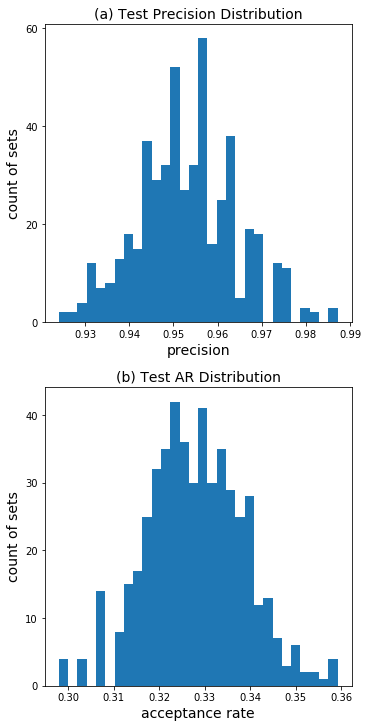

In [9]:

font_size = 14
print('average val_acc: ', mean(val_acc_list))
print('Std val_acc: ', stdev(val_acc_list))

print('average test_acc: ', mean(testlog_acc_list))
print('Std test_acc: ', stdev(testlog_acc_list))

print('average val_elm: ', mean(val_elm_list))
print('Std val_elm: ', stdev(val_elm_list))

print('average test_elm: ', mean(testlog_elm_list))
print('Std test_elm: ', stdev(testlog_elm_list))

print(len(val_acc_list))
#sns.distplot(val_acc_list,bins=15)
#plt.hist(val_acc_list)
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(5, 10))
axs[0].hist(testlog_acc_list,bins= 30)
axs[0].set_title("(a) Test Precision Distribution",fontsize = font_size)
axs[0].set_xlabel("precision",fontsize = font_size)
axs[0].set_ylabel("count of sets",fontsize = font_size)
axs[0].locator_params(axis='y', nbins=5)

axs[1].hist(testlog_elm_list,bins= 30)
axs[1].set_title("(b) Test AR Distribution",fontsize = font_size)
axs[1].set_xlabel("acceptance rate",fontsize = font_size)
axs[1].set_ylabel("count of sets",fontsize = font_size)
axs[1].locator_params(axis='y', nbins=5)

with open('trh_record.txt', 'w') as f:
    for item in trh_list:
        f.write("%s\n" % item)
        
with open('val_acc_record.txt', 'w') as f:
    for item in val_acc_list:
        f.write("%s\n" % item)

with open('val_elm_record.txt', 'w') as f:
    for item in val_elm_list:
        f.write("%s\n" % item)
        
with open('test_acc_record.txt', 'w') as f:
    for item in test_acc_list:
        f.write("%s\n" % item)

with open('test_elm_record.txt', 'w') as f:
    for item in test_elm_list:
        f.write("%s\n" % item)
